In [505]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [506]:
def error_function(y_true,ypred,date):
    #print(y_true)
    #print(ypred)
    import math
    import numpy as np
    y_true=np.array(y_true)
    ypred=np.array(ypred)
    diff=np.subtract(y_true,ypred)
    sqdiff=np.square(diff)
    #print(sqdiff)
    k=math.log(2)/100
    weights=[]
    for i in range(0,len(y_true)):
        temp=date[i].split("-")
        weights.append(math.exp(-(int((int(temp[2])+1)/96)+1)*k))
    weights=np.array(weights)
    product=np.dot(sqdiff,weights)
    root_product=math.sqrt(product)
    loss=(1/np.mean(y_true))*root_product
    print(loss)
    return loss



In [507]:
dataset= pd.read_csv('train.csv')
dataset.head()

,timestamp,main_meter,sub_meter_1,sub_meter_2,building_number
0,2017-04-01 00:00:00,2898.969633,1390.244624,0.000000,1
1,2017-04-01 00:15:00,2531.896894,1087.313897,0.000000,1
2,2017-04-01 00:30:00,2171.649138,695.625737,0.484790,1
3,2017-04-01 00:45:00,2207.299159,615.496571,1.317875,1
4,2017-04-01 01:00:00,2839.441067,1071.573744,0.000000,1


In [508]:
# date=dataset['timestamp']
# date.head()
dataset['Dates'] = pd.to_datetime(dataset['timestamp']).dt.date
dataset['Time'] = pd.to_datetime(dataset['timestamp']).dt.time
# date["Dates"][:]

In [509]:
date = dataset['Dates']
date.head()

0    2017-04-01
1    2017-04-01
2    2017-04-01
3    2017-04-01
4    2017-04-01
Name: Dates, dtype: object

In [510]:
# dataset.dtypes
dataset.index = pd.to_datetime(dataset['timestamp'])

In [511]:
dataset.index

DatetimeIndex(['2017-04-01 00:00:00', '2017-04-01 00:15:00',
               '2017-04-01 00:30:00', '2017-04-01 00:45:00',
               '2017-04-01 01:00:00', '2017-04-01 01:15:00',
               '2017-04-01 01:30:00', '2017-04-01 01:45:00',
               '2017-04-01 02:00:00', '2017-04-01 02:15:00',
               ...
               '2017-12-31 21:30:00', '2017-12-31 21:45:00',
               '2017-12-31 22:00:00', '2017-12-31 22:15:00',
               '2017-12-31 22:30:00', '2017-12-31 22:45:00',
               '2017-12-31 23:00:00', '2017-12-31 23:15:00',
               '2017-12-31 23:30:00', '2017-12-31 23:45:00'],
              dtype='datetime64[ns]', name='timestamp', length=132000, freq=None)

In [512]:
#viewing the column names
list(dataset.columns.values)
b1=dataset.loc[dataset['building_number'] == 4]


In [513]:
b1=b1.drop(['building_number'],axis=1)



In [514]:
b1m=b1['main_meter']
b1s1=b1['sub_meter_1']
b1s2=b1['sub_meter_2']





In [515]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=96).mean()
    rolstd = pd.Series(timeseries).rolling(window=96).std() 
    
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

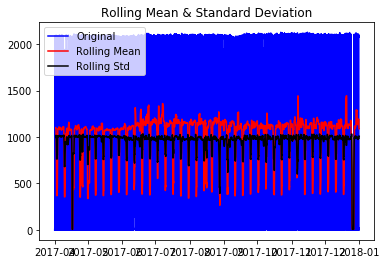

Results of Dickey-Fuller Test:
Test Statistic                   -30.172392
p-value                            0.000000
#Lags Used                        49.000000
Number of Observations Used    26350.000000
Critical Value (1%)               -3.430598
Critical Value (5%)               -2.861650
Critical Value (10%)              -2.566828
dtype: float64


In [516]:
test_stationarity(b1s1) # p value should be less than 0.05 at least to maintain stationarity

In [517]:
b1s1.head()

timestamp
2017-04-01 00:00:00     0.000000
2017-04-01 00:15:00    15.644386
2017-04-01 00:30:00     8.909244
2017-04-01 00:45:00     0.000000
2017-04-01 01:00:00     8.430219
Name: sub_meter_1, dtype: float64

In [518]:
b1s1=b1s1.mask(b1s1==0).fillna(b1s1.mode())

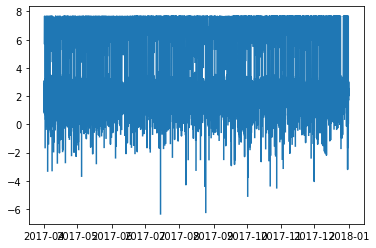

In [519]:
b1m_log = np.log(b1s1)
plt.plot(b1m_log)
b1m_log.dropna(inplace=True)

In [520]:
b1m_log=b1m_log.mask(b1m_log==0).fillna(b1m_log.mean)

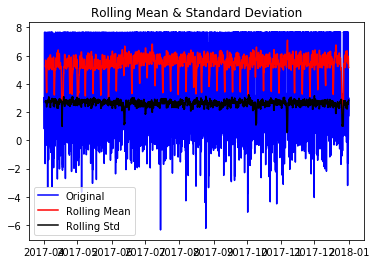

Results of Dickey-Fuller Test:
Test Statistic                   -32.900658
p-value                            0.000000
#Lags Used                        47.000000
Number of Observations Used    22439.000000
Critical Value (1%)               -3.430641
Critical Value (5%)               -2.861669
Critical Value (10%)              -2.566839
dtype: float64


In [521]:
b1m_log = b1m_log.fillna(method='ffill')
b1m_log.dropna(inplace=True)
b1m_log=b1m_log[b1m_log != 0]
test_stationarity(b1m_log)


In [531]:
b1m_log_diff= b1m_log-b1m_log.shift()
b1m_log_diff.dropna(inplace=True)

In [532]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(b1m_log_diff, nlags=40)
lag_pacf = pacf(b1m_log_diff, nlags=40, method='ols')


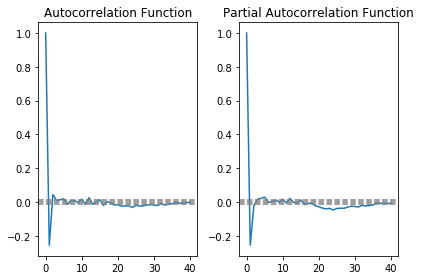

In [533]:
#Plot ACF: 
plt.subplot(121) 
# plt.figure(figsize=(20,10))
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(b1m_log)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(b1m_log)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(b1m_log)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(b1m_log)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [546]:
train_b1m=b1m_log.loc['2017-04-08':'2017-10-31']
test_b1m=b1m_log.loc['2017-10-31':'2017-12-31']
train_dates=date[16954:20544]

In [558]:
final_dates=[]
for i in range(0,len(train_dates)):
  final_dates.append(str(train_dates[i]))
print(type(final_dates[0]))

<class 'str'>


In [536]:
from statsmodels.tsa.arima_model import ARIMA

In [537]:
model=ARIMA(train_b1m,order=(1,1,1))
model_fit=model.fit(disp=0)
output=model_fit.forecast(len(test_b1m)) 
ypred=np.exp(output[0])
error= error_function(np.exp(test_b1m),ypred,final_dates)
print('Score: %.3f' % error)

C:\Users\ianki\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\ianki\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


90.6689556806144
Score: 90.669
